<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Kolchenko (@KolchenkoSergey). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center>Assignment #6
### <center> Beating baselines in "How good is your Medium article?"
    
<img src='../../img/medium_claps.jpg' width=40% />


[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "A6 baseline" (~1.45 Public LB score). Do not forget about our shared ["primitive" baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline) - you'll find something valuable there.

**Your task:**
 1. "Freeride". Come up with good features to beat the baseline "A6 baseline" (for now, public LB is only considered)
 2. You need to name your [team](https://www.kaggle.com/c/how-good-is-your-medium-article/team) (out of 1 person) in full accordance with the [course rating](https://drive.google.com/open?id=19AGEhUQUol6_kNLKSzBsjcGUU3qWy3BNUg8x8IFkO3Q). You can think of it as a part of the assignment. 16 credits for beating the mentioned baseline and correct team naming.

In [156]:
import os
import json
import re
import gc
import pickle

import numpy as np
import pandas as pd

from tqdm import tqdm, tqdm_notebook

from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor, HuberRegressor

The following code will help to throw away all HTML tags from an article content.

In [85]:
def load_obj(path, name):
    with open(f"{path}{name}", "rb") as file:
        object_ = pickle.load(file)
    return object_

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        text = ' '.join(self.fed)
        return re.sub(r"\s+", " ", text)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

def del_spaces(string):
    return re.sub(r"\s+", " ", string)

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [4]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            content = strip_tags(json_data["content"]).lower()
            title = del_spaces(json_data["title"].replace("–", "")).lower()
            
            feature_files[0].write(content + "\n")
            feature_files[1].write(json_data["published"]["$date"].lower() + "\n")
            feature_files[2].write(title + "\n")
            feature_files[3].write(json_data["meta_tags"]["author"].strip().lower() + "\n")
            
    for file in feature_files:
        file.close()
        
    return None

In [5]:
PATH_TO_DATA = '/Users/alex/All/programming/Python/Jupyter /kaggle_medium/raw_data/' # modify this if you need to

In [81]:
# extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)


1703it [35:04,  1.24s/it] 


Exception ignored in: <function tqdm.__del__ at 0x113987268>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/_tqdm.py", line 889, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/_tqdm.py", line 1095, in close
    self._decr_instances(self)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/_tqdm.py", line 454, in _decr_instances
    cls.monitor.exit()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 1029, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [86]:
# extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

# Много говнокода

In [89]:
%%time
# You code here
tf_idf_content = TfidfVectorizer(ngram_range=(1,2), max_features=100000)

with open(PATH_TO_DATA + "train_content.txt", "r") as content:
    X_train_content_sparse = tf_idf_content.fit_transform(content)

with open(PATH_TO_DATA + "test_content.txt", "r") as content:
    X_test_content_sparse = tf_idf_content.transform(content)
    
with open(PATH_TO_DATA + "train_content_idf.pkl", "wb") as file:
    pickle.dump(X_train_content_sparse, file)
    
with open(PATH_TO_DATA + "test_content_idf.pkl", "wb") as file:
    pickle.dump(X_test_content_sparse, file)    

gc.collect()

CPU times: user 9min 44s, sys: 1min 21s, total: 11min 5s
Wall time: 11min 55s


In [91]:
%%time
tf_idf_titles = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

with open(PATH_TO_DATA + "train_title.txt", "r") as titles:
    X_train_title_sparse = tf_idf_titles.fit_transform(titles)
    
with open(PATH_TO_DATA + "test_title.txt", "r") as titles:
    X_test_title_sparse = tf_idf_titles.transform(titles)
    
with open(PATH_TO_DATA + "train_title_idf.pkl", "wb") as file:
    pickle.dump(X_train_title_sparse, file)
    
with open(PATH_TO_DATA + "test_title_idf.pkl", "wb") as file:
    pickle.dump(X_test_title_sparse, file)    

    
gc.collect()

CPU times: user 8.41 s, sys: 6.92 s, total: 15.3 s
Wall time: 19.8 s


# Loading data

In [107]:
%%time 
ohe = OneHotEncoder()

with open(PATH_TO_DATA + "train_author.txt", "r") as authors:
    authors_train = pd.read_csv(authors, sep="\n", header=None)
    
with open(PATH_TO_DATA + "test_author.txt", "r") as authors:
    authors_test = pd.read_csv(authors, sep="\n", header=None)
     
split_indx = len(authors_train)
authors_full = ohe.fit_transform(pd.concat([authors_train, authors_test], axis=0))

    
X_train_author_sparse = authors_full[:split_indx]
X_test_author_sparse = authors_full[split_indx:]

CPU times: user 185 ms, sys: 28.7 ms, total: 214 ms
Wall time: 219 ms


In [218]:
ohe.get_feature_names()

array(['x0_!shita', 'x0_#angels', 'x0_#cphftw', ..., 'x0_😎 nate andorsky',
       'x0_😎 sam hurley 😎', 'x0_🚀 marine wetzel ☀️'], dtype=object)

In [88]:
X_train_content_sparse = load_obj(PATH_TO_DATA, "train_content_idf.pkl")
X_test_content_sparse = load_obj(PATH_TO_DATA, "test_content_idf.pkl")

X_train_title_sparse = load_obj(PATH_TO_DATA, "train_title_idf.pkl")
X_test_title_sparse = load_obj(PATH_TO_DATA, "test_title_idf.pkl")

**Join all sparse matrices.**

In [108]:
# del time features, just test run for now
X_train_sparse = hstack([X_train_content_sparse, X_train_title_sparse,
                         X_train_author_sparse]).tocsr()

In [109]:
X_test_sparse = hstack([X_test_content_sparse, X_test_title_sparse,
                        X_test_author_sparse]).tocsr()

In [113]:
X_train_sparse.shape

(62313, 243859)

**Read train target and split data for validation.**

In [114]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [115]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [188]:
%%time
# You code here
model = Ridge()

model.fit(X_train_part_sparse, y_train_part)

CPU times: user 44.9 s, sys: 1.64 s, total: 46.6 s
Wall time: 49.2 s


In [196]:
y_pred = model.predict(X_valid_sparse)

In [199]:
mean_absolute_error(y_valid, y_pred)

1.0705941173274953

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [208]:
# You code here
model_full = Ridge()
model_full.fit(X_train_sparse, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [228]:
(model_full.coef_[X_test_content_sparse.shape[1] + X_train_title_sparse.shape[1]:]).shape

(43859,)

In [179]:
y_test = model_full.predict(X_test_sparse)

In [124]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [125]:
write_submission_file(y_test, os.path.join(PATH_TO_DATA,
                                                    'assignment6_medium_submission.csv'))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [127]:
write_submission_file(np.zeros_like(y_test), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [203]:
4.33328 - y_test.mean()

1.1312977756494194

In [204]:
ridge_test_pred_modif = y_test + 1.13129# You code here


In [205]:
ridge_test_pred_modif.mean()

4.333272224350581

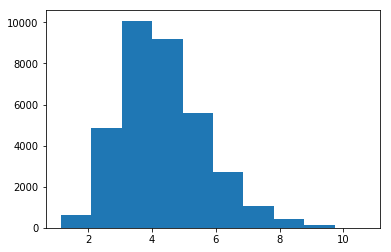

In [206]:
plt.hist(ridge_test_pred_modif);

In [207]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment6_medium_submission_with_hack.csv'))

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!

<img src='../../img/kaggle_shakeup.png' width=50%>